In [1]:
from typing import Union

from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, ExpSineSquared
from sklearn.linear_model import SGDRegressor, LinearRegression, BayesianRidge
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C ,WhiteKernel as Wht,Matern as matk
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_absolute_error,
)

In [2]:
def fit_and_validate_model(
    model: Union[SGDRegressor, SVR, GradientBoostingRegressor],
    train_X: np.ndarray,
    train_y: np.ndarray,
    val_X: np.ndarray,
    val_y: np.ndarray,
) -> Union[SGDRegressor, SVR, GradientBoostingRegressor]:
    model = model.fit(train_X, train_y)
    val_preds = model.predict(val_X)
    r2 = r2_score(val_y, val_preds)
    mape = mean_absolute_percentage_error(val_y, val_preds)
    mse = mean_squared_error(val_y, val_preds)
    mae = mean_absolute_error(val_y, val_preds)
    print(f"Validation R2 score: {r2}")
    print(f"MAPE: {mape}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    return model, {"r2": r2, "mape": mape, "mae": mae, "mse": mse}


def get_test_score(
    model: Union[SGDRegressor, SVR, GradientBoostingRegressor],
    X: np.ndarray,
    y: np.ndarray,
) -> None:
    print(f"Validation R2 score: {r2_score(y, model.predict(X))}")
    print(f"MSE: {mean_squared_error(y, model.predict(X))}")
    return None

In [3]:
def gpregression(Xtrain,Ytrain,Nfeature):    
    cmean=[1.0]*Nfeature
    cbound=[[1e-6, 1e6]]*Nfeature
    kernel = C(1.0, (1e-6,1e6)) * matk(cmean,cbound,1.2) + Wht(1.0, (1e-6, 1e6))  # Matern kernel
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=False)
    # gp.fit(Xtrain, Ytrain)
    return gp

In [4]:
train_data = pd.read_csv("../data/processed/norm_train.csv")
val_data = pd.read_csv("../data/processed/norm_val.csv")
train_X, train_y = train_data.drop("pt_loss", axis=1), train_data["pt_loss"]
val_X, val_y = val_data.drop("pt_loss", axis=1), val_data["pt_loss"]

In [5]:
blr, blr_metrics = fit_and_validate_model(
    BayesianRidge(n_iter=1000), train_X.values, train_y.values, val_X.values, val_y.values
)

Validation R2 score: 0.7741230885668111
MAPE: 0.31020720454566797
MAE: 0.044423450610857604
MSE: 0.003628718020325516


In [6]:
gp, gp_metrics = fit_and_validate_model(
    gpregression(None, None, 7), train_X.values, train_y.values, val_X.values, val_y.values
)

Validation R2 score: 0.9123924893695775
MAPE: 0.09277451004201702
MAE: 0.016790456110215405
MSE: 0.0014074167674924321


In [7]:
lin_reg, lin_reg_metrics = fit_and_validate_model(
    LinearRegression(), train_X.values, train_y.values, val_X.values, val_y.values
)

Validation R2 score: 0.7739414602773229
MAPE: 0.3107417043389817
MAE: 0.044469729794018684
MSE: 0.0036316358831689766


In [9]:
svm_rbf_kernel, svm_rbf_kernel_metrics = fit_and_validate_model(
    SVR(kernel="poly"), train_X.values, train_y.values, val_X.values, val_y.values
)

Validation R2 score: 0.7318971444684432
MAPE: 0.4486470897465031
MAE: 0.053965566795555184
MSE: 0.004307078828886189


In [10]:
gpr, gpr_merics = fit_and_validate_model(
    GaussianProcessRegressor(kernel=1. * RationalQuadratic(3, 3)), train_X.values, train_y.values, val_X.values, val_y.values
)

Validation R2 score: 0.862858826984539
MAPE: 0.09417975569216008
MAE: 0.01887692758071621
MSE: 0.002203176246267115


In [11]:
rand_forest, rand_forest_metrics = fit_and_validate_model(
    RandomForestRegressor(),
    train_X.values,
    train_y.values,
    val_X.values,
    val_y.values,
)

Validation R2 score: 0.8436748067237285
MAPE: 0.07447777532055032
MAE: 0.01475547846153845
MSE: 0.00251136799362631


In [12]:
grad_boost_reg, grad_boost_reg_metrics = fit_and_validate_model(
    GradientBoostingRegressor(init=gpregression(None, None, 7)),
    train_X.values,
    train_y.values,
    val_X.values,
    val_y.values,
)

Validation R2 score: 0.927501466464522
MAPE: 0.07980287878392887
MAE: 0.014880527890241406
MSE: 0.0011646906867025084


Придумаем визуализацию

In [14]:
def visualize_residuals(
    model: Union[LinearRegression, SVR, GradientBoostingRegressor],
    val_X: np.ndarray,
    val_y: np.ndarray,
) -> None:
    val_preds = model.predict(val_X)
    residuals = val_y - val_preds
    plt.figure(figsize=(5, 5))
    plt.title("Residuals")
    plt.hist(residuals, bins=len(val_y) // 10)
    plt.show()
    return None


def visualize_pairplot(
    model: Union[LinearRegression, SVR, GradientBoostingRegressor],
    val_X: np.ndarray,
    val_y: np.ndarray,
) -> None:
    val_preds = model.predict(val_X)
    plt.figure(figsize=(5, 5))
    plt.title("Pair plot")
    plt.scatter(val_preds, val_y)
    plt.ylabel("Predictions")
    plt.xlabel("Ground Truth's")
    plt.show()
    return None


def visualize_metrics(
    scores: list[float], labels: list[str], metric_name: str
) -> None:
    plt.figure(figsize=(7, 4))
    plt.title(f"{metric_name} values")
    plt.bar_label(
        plt.bar(labels, scores),
        [round(score, 4) for score in scores],
        label_type="center",
        c='white'
    )
    plt.xlabel("Model")
    plt.ylabel("Metric value")
    plt.savefig(f"../artifacts/{metric_name}.png")
    return None

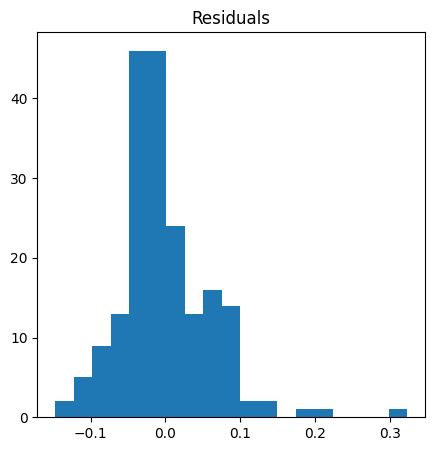

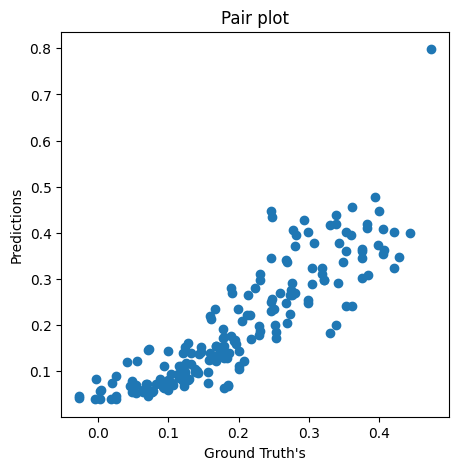

In [15]:
visualize_residuals(lin_reg, val_X.values, val_y.values)
visualize_pairplot(lin_reg, val_X.values, val_y.values)

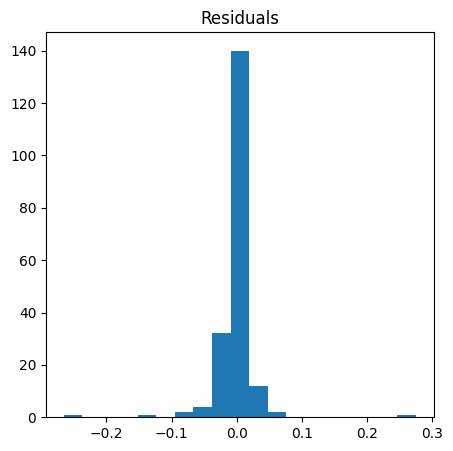

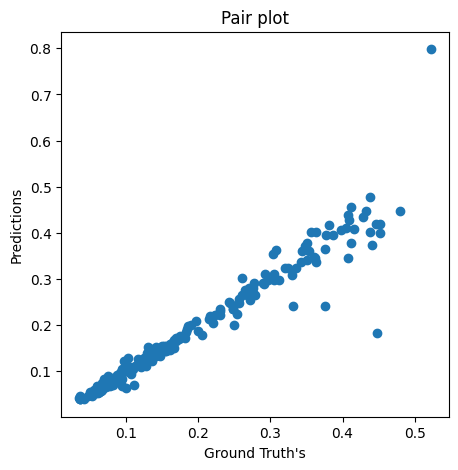

In [16]:
visualize_residuals(grad_boost_reg, val_X.values, val_y.values)
visualize_pairplot(grad_boost_reg, val_X.values, val_y.values)

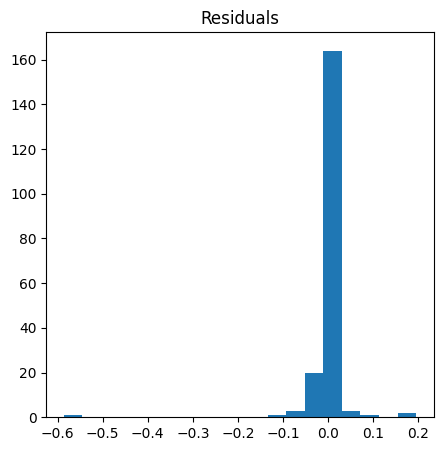

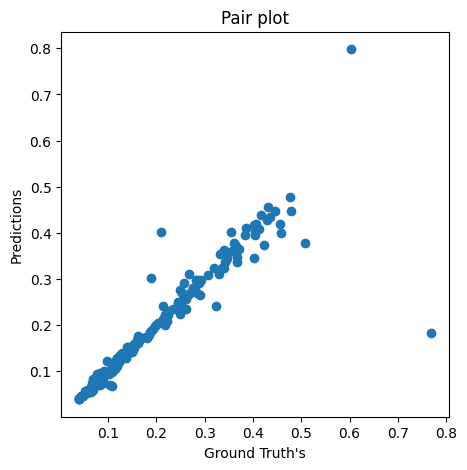

In [17]:
visualize_residuals(rand_forest, val_X.values, val_y.values)
visualize_pairplot(rand_forest, val_X.values, val_y.values)

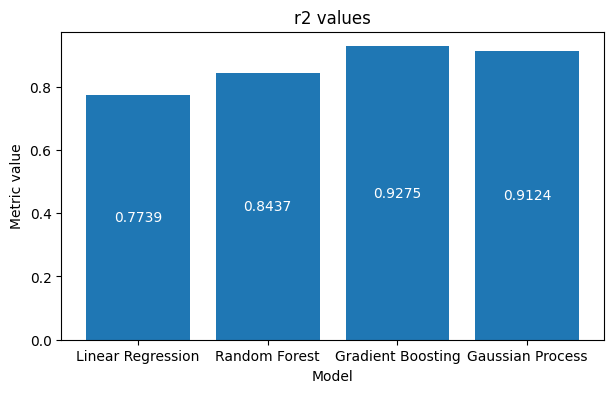

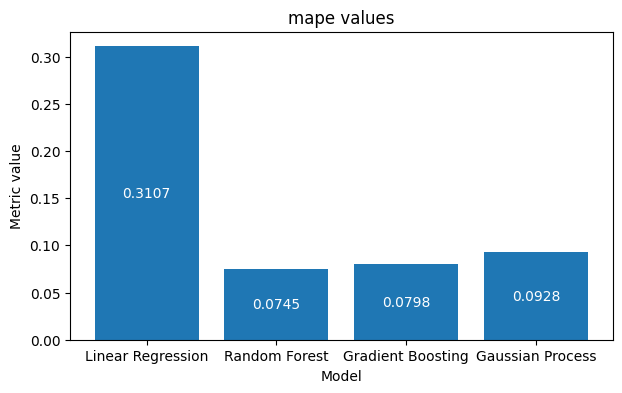

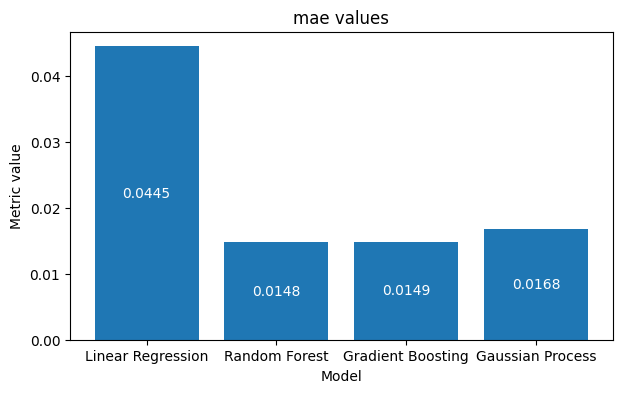

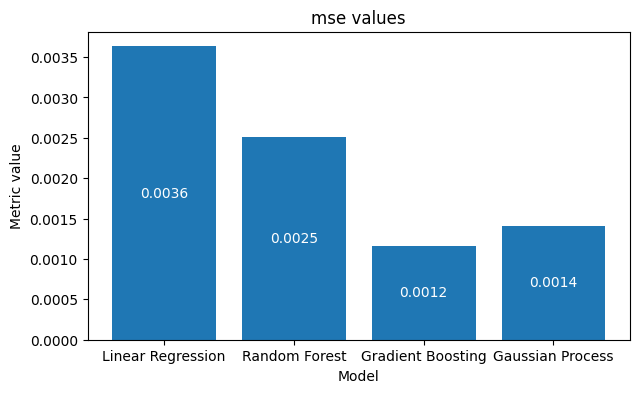

In [18]:
for key in lin_reg_metrics.keys():
    visualize_metrics(
        [metric_dict.get(key) for metric_dict in [lin_reg_metrics, rand_forest_metrics, grad_boost_reg_metrics, gp_metrics]],
        ["Linear Regression", "Random Forest", "Gradient Boosting", "Gaussian Process"],
        key
    )

In [4]:
cbr, cbr_metrics = fit_and_validate_model(
    CatBoostRegressor(iterations=10, od_type='IncToDec'), train_X.values, train_y.values, val_X.values, val_y.values
)

Learning rate set to 0.5
0:	learn: 0.0928969	total: 47.4ms	remaining: 427ms
1:	learn: 0.0723956	total: 48ms	remaining: 192ms
2:	learn: 0.0639733	total: 48.4ms	remaining: 113ms
3:	learn: 0.0599604	total: 48.8ms	remaining: 73.2ms
4:	learn: 0.0560777	total: 49.6ms	remaining: 49.6ms
5:	learn: 0.0539470	total: 50.3ms	remaining: 33.5ms
6:	learn: 0.0534690	total: 52.9ms	remaining: 22.7ms
7:	learn: 0.0510600	total: 53.3ms	remaining: 13.3ms
8:	learn: 0.0505619	total: 53.7ms	remaining: 5.97ms
9:	learn: 0.0481382	total: 54.1ms	remaining: 0us
Validation R2 score: 0.9222456440998104
MAPE: 0.11262603561121114
MAE: 0.018420813430738245
MSE: 0.0012491255995293576


In [5]:
cbr.calc_feature_statistics(
    val_X,
    val_y,
    plot=True,
    max_cat_features_on_plot=10,
    thread_count=-1,
)

{'0': {'borders': array([0.0125, 0.06  ], dtype=float32),
  'binarized_feature': array([0, 1, 0, 2, 2, 2, 1, 1, 0, 1, 0, 0, 1, 2, 1, 1, 0, 2, 0, 2, 0, 0,
         1, 0, 1, 2, 1, 2, 1, 2, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
         1, 0, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 2, 2, 2, 0, 2, 2, 1,
         0, 0, 2, 2, 0, 2, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 2, 0, 0, 2, 2, 0,
         0, 2, 0, 2, 2, 2, 0, 0, 2, 1, 2, 2, 2, 0, 1, 1, 2, 1, 0, 0, 1, 0,
         2, 0, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 2, 2, 1, 2, 0, 2, 0, 0, 1, 1,
         2, 0, 1, 0, 1, 2, 1, 1, 1, 2, 0, 1, 1, 0, 0, 1, 2, 2, 2, 1, 2, 2,
         0, 1, 1, 0, 1, 1, 1, 0, 0, 2, 1, 0, 2, 0, 0, 0, 1, 0, 1, 0, 0, 2,
         1, 2, 0, 1, 0, 0, 1, 1, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2, 1]),
  'mean_target': array([0.1360491 , 0.13769285, 0.32026038], dtype=float32),
  'mean_weighted_target': array([], dtype=float32),
  'mean_prediction': array([0.13664305, 0.14104918, 0.32249907], dtype=float32),
  'objects_per_bin': array([68, 67, 60], dt